In [17]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import warnings
warnings.filterwarnings('ignore')

## Generate Data

In [19]:
seed = 312

import random
np.random.seed(seed)
random.seed(seed)

In [20]:
from simulate import data_config
from synthetics_utils import generate_synthetic_data
from visualization_utils import visualize_data, display_scores, plot_slice_scores

from metal.end_model import EndModel
from metal.contrib.slicing.online_dp import LinearModule, MLPModule, SliceDPModel

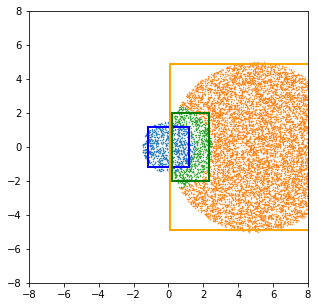

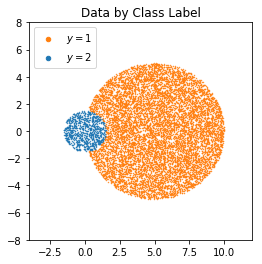

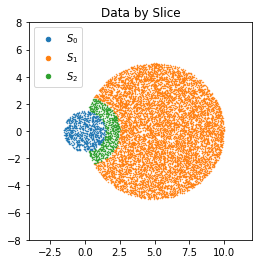

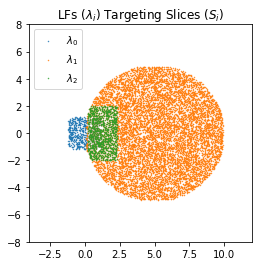

In [29]:
# from deathstar_data import generate_deathstar_data, generate_uniform_circle_data, get_circle_idx
from data_generators import generate_pacman_data
from synthetics_utils import shuffle_matrices, lf_circ_idx_for_slice_precision

config = {
    'N': 10000,
    'mus': np.array([[0,  0], [5, 0]]),
    'variances': [1.5, 5],
    'labels': [2, 1],
    'lf_metrics': [('recall', 1.0), ('recall', 1.0)],
}

X, Y, C, L = generate_pacman_data(config, plotting=True)

visualize_data(X, Y, C, L)

### Validating that we can reproduce the L matrix 
Train attention model with `slice_weight=1.0`. Then, try to repredict the `L_test` values using the `L_head`.

In [8]:
# model_configs = {
#     "AttentionModel": {
#         "base_model_class" : SliceDPModel,
#         "base_model_init_kwargs": {
#             "reweight": True,
#             "r": 5,
#             "slice_weight": 1.0, # NOTE: slice weight 1.0 means we are only backprop on L_head
#             "L_weights": None
#         },
# #         "input_module_class": LinearModule,
#         "input_module_class": MLPModule,
#         "input_module_init_kwargs": {
#             'input_dim': 2,
#             'middle_dims': [5],
#             'bias': True,
#             'output_dim': 5
#          },
#         "train_on_L": True,
#     }
# }

In [9]:
# from simulate import train_models

# # DEBUG: gt labels for training [prob_1, prob2]
# Y_cat = np.zeros((Y_train.shape[0], 2))
# Y_cat[:,0] = Y_train == 1
# Y_cat[:,1] = Y_train == 2
# Y_cat = Y_cat.astype(np.float32)

# config['accs'] = np.array(accs)
# print (config['accs'])
# # config['accs'] = np.array([1.0, 1.0])
# experiment_config['use_weak_labels_from_gen_model'] = True
# experiment_config['x_var'] = None
# experiment_config['num_trials'] = 1
# experiment_config['verbose'] = True
# experiment_config['visualize_data'] = True
# experiment_config['train_kwargs']['print_every'] = 1
# experiment_config['train_kwargs']['l2'] = 0
# experiment_config['train_kwargs']['lr'] = 0.001
# experiment_config['train_kwargs']['n_epochs'] = 40
# experiment_config['seed'] = 333

# trained_models = train_models(
#     (X_train, X_dev),
#     (Y_tilde_accs, Y_dev),
#     (L_train, L_dev),
#     model_configs,
#     experiment_config["train_kwargs"],
#     verbose=experiment_config["verbose"],
#     seed=experiment_config.get("seed", None)
# )


In [10]:
# from visualization_utils import compare_prediction_plots
# compare_prediction_plots((X_test, Y_test), trained_models, C_test)

In [11]:
# from metal.metrics import accuracy_score
# import torch.nn.functional as F

# X_test_L_head = X_test
# L_test_L_head = L_test
# # overlap_test_L_head = overlap_test


# slice_preds = F.sigmoid(
#     trained_models['AttentionModel'].forward_L(X_test_L_head)
# ).detach().numpy()


# preds = (slice_preds > 0.5) * 1
# L_gt = L_test_L_head.copy()
# L_gt[L_gt != 0] = 1
# print ('predicted L distribution:', np.sum(preds, axis=0))
# print ('accuracy over LF0:', accuracy_score(L_gt[:, 0], preds[:, 0]))
# print ('accuracy over LF1:', accuracy_score(L_gt[:, 1], preds[:, 1]))
# print ('accuracy over LF2:', accuracy_score(L_gt[:, 2], preds[:, 2]))


# # print ('accuracy over overlap for LF 0:', 
# #        accuracy_score(L_gt[overlap_test_L_head, 0], preds[overlap_test_L_head, 0]))

# # print ('accuracy over overlap for LF 1:', 
# #       accuracy_score(L_gt[overlap_test_L_head, 1], preds[overlap_test_L_head, 1]))


### Compare EndModel to AttentionModel

In [12]:
from metal.contrib.slicing.experiment_utils import create_data_loader

def train_orig(config, Ls, Xs, Ys, Zs):

    input_dim = 2
    m = 3
    input_module = MLPModule(input_dim, 10, [10], bias=True)
    slice_orig = SliceDPModel(
        input_module, r=10, m=m, reweight=False, slice_weight=0.1, 
        verbose=False)

    train_loader = create_data_loader(
        Ls, Xs, Ys, Zs, config, "train"
    )
    
    dev_loader = create_data_loader(Ls, Xs, Ys, Zs, config, "dev")
    
    slice_orig.train_model(
        train_loader,
        dev_data=dev_loader,
        disable_prog_bar=True,
        **config['train_kwargs']
    )
    
    return slice_orig

In [13]:
from metal.contrib.slicing.online_dp import SliceHatModel, MLPModule
from metal.end_model import EndModel

# NOTE: each model can take a "train_kwargs"

### SHARED PIECES
train_kwargs = {
    "verbose": True,
    "n_epochs": 20,
    "lr": 0.005,
    "l2": 1e-7,
}
end_model_init_kwargs = {
    "layer_out_dims": [2, 10, 10, 2],
}

### FULL CONFIGS
dp_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
}

uni_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
}

up_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "upweight_search_space": {"range": [1, 5]},
    "max_search": 5
}

moe_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "expert_train_kwargs": {"n_epochs": 10, "verbose": False},
    "train_kwargs": {"verbose": False},
    "gating_dim": 5
}

print("WARNING: Pay attention to slice weight!")
sm_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "slice_weight": 0.1,
        "reweight": True,
    }
}

orig = {
    'train_kwargs': train_kwargs,
    'slice_kwargs': {
        'slice_weight': 0.1,
        'reweight': True
    }
}

Pepper: 0.1
Salt: 42
[Trial 0]


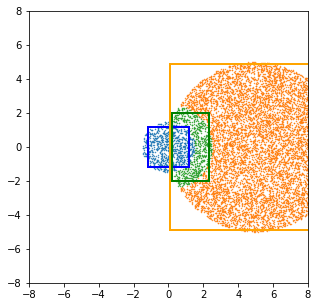

---------- Training orig ----------
Added pepper=0.1 random negatives on 3/3 LFs
Saving model at iteration 0 with best score 0.934
[E:0]	Train Loss: 5.758	Dev accuracy: 0.934
Saving model at iteration 1 with best score 0.942
[E:1]	Train Loss: 4.459	Dev accuracy: 0.942
Saving model at iteration 2 with best score 0.953
[E:2]	Train Loss: 4.255	Dev accuracy: 0.953
Saving model at iteration 3 with best score 0.955
[E:3]	Train Loss: 4.212	Dev accuracy: 0.955
[E:4]	Train Loss: 4.207	Dev accuracy: 0.952
[E:5]	Train Loss: 4.204	Dev accuracy: 0.955
[E:6]	Train Loss: 4.191	Dev accuracy: 0.949
Saving model at iteration 7 with best score 0.955
[E:7]	Train Loss: 4.194	Dev accuracy: 0.955
Saving model at iteration 8 with best score 0.956
[E:8]	Train Loss: 4.185	Dev accuracy: 0.956
[E:9]	Train Loss: 4.185	Dev accuracy: 0.955
Saving model at iteration 10 with best score 0.956
[E:10]	Train Loss: 4.188	Dev accuracy: 0.956
Saving model at iteration 11 with best score 0.957
[E:11]	Train Loss: 4.182	Dev acc

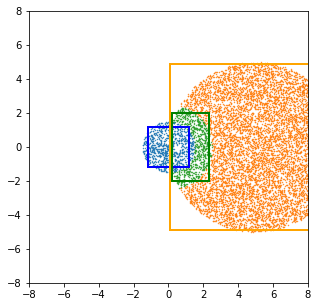

---------- Training orig ----------
Added pepper=0.1 random negatives on 3/3 LFs
Saving model at iteration 0 with best score 0.947
[E:0]	Train Loss: 5.327	Dev accuracy: 0.947
Saving model at iteration 1 with best score 0.955
[E:1]	Train Loss: 4.295	Dev accuracy: 0.955
Saving model at iteration 2 with best score 0.957
[E:2]	Train Loss: 4.282	Dev accuracy: 0.957
Saving model at iteration 3 with best score 0.958
[E:3]	Train Loss: 4.262	Dev accuracy: 0.958
[E:4]	Train Loss: 4.266	Dev accuracy: 0.958
Saving model at iteration 5 with best score 0.959
[E:5]	Train Loss: 4.253	Dev accuracy: 0.959
Saving model at iteration 6 with best score 0.959
[E:6]	Train Loss: 4.257	Dev accuracy: 0.959
[E:7]	Train Loss: 4.253	Dev accuracy: 0.959
[E:8]	Train Loss: 4.260	Dev accuracy: 0.959
[E:9]	Train Loss: 4.250	Dev accuracy: 0.959
[E:10]	Train Loss: 4.256	Dev accuracy: 0.959
[E:11]	Train Loss: 4.248	Dev accuracy: 0.959
[E:12]	Train Loss: 4.240	Dev accuracy: 0.959
[E:13]	Train Loss: 4.233	Dev accuracy: 0.959

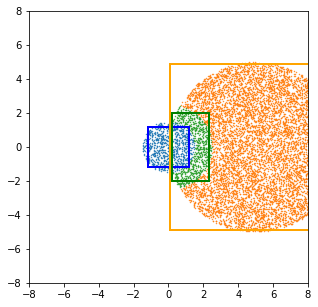

---------- Training orig ----------
Added pepper=0.1 random negatives on 3/3 LFs
Saving model at iteration 0 with best score 0.930
[E:0]	Train Loss: 5.650	Dev accuracy: 0.930
[E:1]	Train Loss: 4.416	Dev accuracy: 0.927
Saving model at iteration 2 with best score 0.939
[E:2]	Train Loss: 4.319	Dev accuracy: 0.939
Saving model at iteration 3 with best score 0.942
[E:3]	Train Loss: 4.278	Dev accuracy: 0.942
[E:4]	Train Loss: 4.252	Dev accuracy: 0.927
Saving model at iteration 5 with best score 0.952
[E:5]	Train Loss: 4.226	Dev accuracy: 0.952
Saving model at iteration 6 with best score 0.952
[E:6]	Train Loss: 4.218	Dev accuracy: 0.952
Saving model at iteration 7 with best score 0.957
[E:7]	Train Loss: 4.207	Dev accuracy: 0.957
[E:8]	Train Loss: 4.210	Dev accuracy: 0.943
Saving model at iteration 9 with best score 0.958
[E:9]	Train Loss: 4.209	Dev accuracy: 0.958
[E:10]	Train Loss: 4.205	Dev accuracy: 0.957
[E:11]	Train Loss: 4.203	Dev accuracy: 0.942
[E:12]	Train Loss: 4.196	Dev accuracy: 

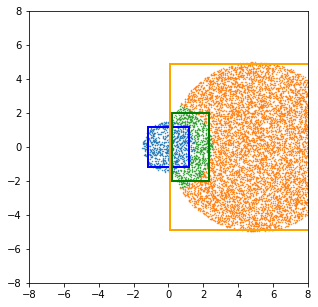

---------- Training orig ----------
Added pepper=0.1 random negatives on 3/3 LFs
Saving model at iteration 0 with best score 0.938
[E:0]	Train Loss: 5.324	Dev accuracy: 0.938
[E:1]	Train Loss: 4.227	Dev accuracy: 0.937
Saving model at iteration 2 with best score 0.954
[E:2]	Train Loss: 4.175	Dev accuracy: 0.954
[E:3]	Train Loss: 4.159	Dev accuracy: 0.952
Saving model at iteration 4 with best score 0.955
[E:4]	Train Loss: 4.146	Dev accuracy: 0.955
[E:5]	Train Loss: 4.147	Dev accuracy: 0.951
Saving model at iteration 6 with best score 0.955
[E:6]	Train Loss: 4.140	Dev accuracy: 0.955
Saving model at iteration 7 with best score 0.957
[E:7]	Train Loss: 4.138	Dev accuracy: 0.957
[E:8]	Train Loss: 4.129	Dev accuracy: 0.955
[E:9]	Train Loss: 4.131	Dev accuracy: 0.957
[E:10]	Train Loss: 4.128	Dev accuracy: 0.949
[E:11]	Train Loss: 4.129	Dev accuracy: 0.957
Saving model at iteration 12 with best score 0.958
[E:12]	Train Loss: 4.123	Dev accuracy: 0.958
Saving model at iteration 13 with best scor

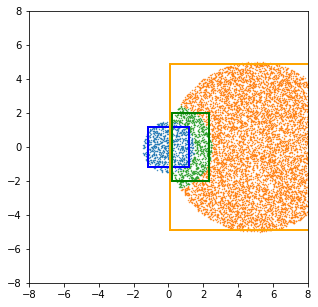

---------- Training orig ----------
Added pepper=0.1 random negatives on 3/3 LFs
Saving model at iteration 0 with best score 0.920
[E:0]	Train Loss: 6.131	Dev accuracy: 0.920
Saving model at iteration 1 with best score 0.946
[E:1]	Train Loss: 4.914	Dev accuracy: 0.946
Saving model at iteration 2 with best score 0.947
[E:2]	Train Loss: 4.628	Dev accuracy: 0.947
[E:3]	Train Loss: 4.522	Dev accuracy: 0.937
[E:4]	Train Loss: 4.488	Dev accuracy: 0.941
[E:5]	Train Loss: 4.465	Dev accuracy: 0.938
[E:6]	Train Loss: 4.452	Dev accuracy: 0.942
[E:7]	Train Loss: 4.446	Dev accuracy: 0.946
Saving model at iteration 8 with best score 0.951
[E:8]	Train Loss: 4.428	Dev accuracy: 0.951
[E:9]	Train Loss: 4.416	Dev accuracy: 0.949
[E:10]	Train Loss: 4.406	Dev accuracy: 0.947
Saving model at iteration 11 with best score 0.953
[E:11]	Train Loss: 4.409	Dev accuracy: 0.953
Saving model at iteration 12 with best score 0.955
[E:12]	Train Loss: 4.391	Dev accuracy: 0.955
[E:13]	Train Loss: 4.387	Dev accuracy: 0.9

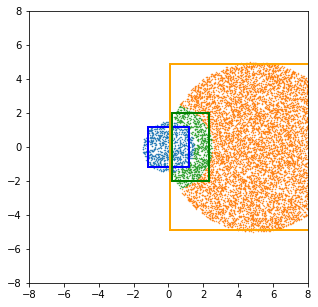

---------- Training orig ----------
Added pepper=0.1 random negatives on 3/3 LFs
Saving model at iteration 0 with best score 0.913
[E:0]	Train Loss: 5.781	Dev accuracy: 0.913
Saving model at iteration 1 with best score 0.940
[E:1]	Train Loss: 4.451	Dev accuracy: 0.940
Saving model at iteration 2 with best score 0.951
[E:2]	Train Loss: 4.250	Dev accuracy: 0.951
[E:3]	Train Loss: 4.232	Dev accuracy: 0.927
Saving model at iteration 4 with best score 0.959
[E:4]	Train Loss: 4.222	Dev accuracy: 0.959
[E:5]	Train Loss: 4.220	Dev accuracy: 0.957
Saving model at iteration 6 with best score 0.959
[E:6]	Train Loss: 4.210	Dev accuracy: 0.959
[E:7]	Train Loss: 4.218	Dev accuracy: 0.936
[E:8]	Train Loss: 4.208	Dev accuracy: 0.959
[E:9]	Train Loss: 4.209	Dev accuracy: 0.959
[E:10]	Train Loss: 4.209	Dev accuracy: 0.959
[E:11]	Train Loss: 4.199	Dev accuracy: 0.959
[E:12]	Train Loss: 4.196	Dev accuracy: 0.959
[E:13]	Train Loss: 4.201	Dev accuracy: 0.959
[E:14]	Train Loss: 4.192	Dev accuracy: 0.959
[E:1

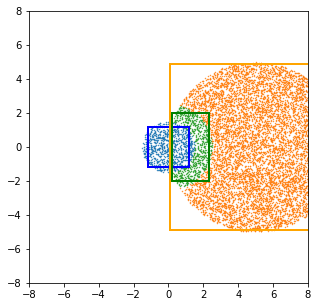

---------- Training orig ----------
Added pepper=0.1 random negatives on 3/3 LFs
Saving model at iteration 0 with best score 0.922
[E:0]	Train Loss: 6.333	Dev accuracy: 0.922
Saving model at iteration 1 with best score 0.935
[E:1]	Train Loss: 4.426	Dev accuracy: 0.935
Saving model at iteration 2 with best score 0.939
[E:2]	Train Loss: 4.313	Dev accuracy: 0.939
Saving model at iteration 3 with best score 0.942
[E:3]	Train Loss: 4.294	Dev accuracy: 0.942
Saving model at iteration 4 with best score 0.945
[E:4]	Train Loss: 4.277	Dev accuracy: 0.945
[E:5]	Train Loss: 4.284	Dev accuracy: 0.945
Saving model at iteration 6 with best score 0.946
[E:6]	Train Loss: 4.269	Dev accuracy: 0.946
[E:7]	Train Loss: 4.262	Dev accuracy: 0.946
Saving model at iteration 8 with best score 0.947
[E:8]	Train Loss: 4.266	Dev accuracy: 0.947
Saving model at iteration 9 with best score 0.949
[E:9]	Train Loss: 4.255	Dev accuracy: 0.949
[E:10]	Train Loss: 4.260	Dev accuracy: 0.947
[E:11]	Train Loss: 4.249	Dev accur

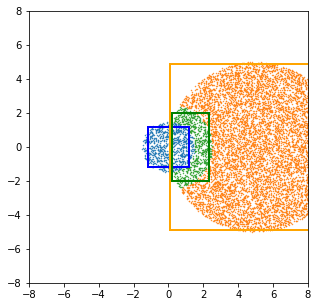

---------- Training orig ----------
Added pepper=0.1 random negatives on 3/3 LFs
Saving model at iteration 0 with best score 0.940
[E:0]	Train Loss: 5.238	Dev accuracy: 0.940
[E:1]	Train Loss: 4.329	Dev accuracy: 0.934
Saving model at iteration 2 with best score 0.942
[E:2]	Train Loss: 4.280	Dev accuracy: 0.942
[E:3]	Train Loss: 4.265	Dev accuracy: 0.940
Saving model at iteration 4 with best score 0.946
[E:4]	Train Loss: 4.251	Dev accuracy: 0.946
Saving model at iteration 5 with best score 0.948
[E:5]	Train Loss: 4.246	Dev accuracy: 0.948
Saving model at iteration 6 with best score 0.950
[E:6]	Train Loss: 4.245	Dev accuracy: 0.950
Saving model at iteration 7 with best score 0.952
[E:7]	Train Loss: 4.242	Dev accuracy: 0.952
Saving model at iteration 8 with best score 0.954
[E:8]	Train Loss: 4.244	Dev accuracy: 0.954
[E:9]	Train Loss: 4.232	Dev accuracy: 0.953
[E:10]	Train Loss: 4.226	Dev accuracy: 0.951
[E:11]	Train Loss: 4.233	Dev accuracy: 0.954
Saving model at iteration 12 with best 

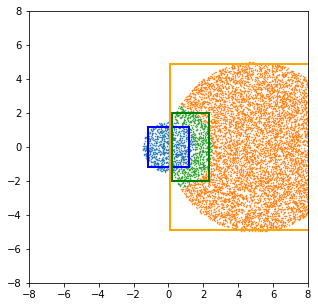

---------- Training orig ----------
Added pepper=0.1 random negatives on 3/3 LFs
Saving model at iteration 0 with best score 0.943
[E:0]	Train Loss: 5.710	Dev accuracy: 0.943
Saving model at iteration 1 with best score 0.944
[E:1]	Train Loss: 4.358	Dev accuracy: 0.944
Saving model at iteration 2 with best score 0.954
[E:2]	Train Loss: 4.231	Dev accuracy: 0.954
Saving model at iteration 3 with best score 0.955
[E:3]	Train Loss: 4.211	Dev accuracy: 0.955
Saving model at iteration 4 with best score 0.960
[E:4]	Train Loss: 4.207	Dev accuracy: 0.960
[E:5]	Train Loss: 4.197	Dev accuracy: 0.958
Saving model at iteration 6 with best score 0.961
[E:6]	Train Loss: 4.192	Dev accuracy: 0.961
Saving model at iteration 7 with best score 0.963
[E:7]	Train Loss: 4.193	Dev accuracy: 0.963
[E:8]	Train Loss: 4.180	Dev accuracy: 0.963
Saving model at iteration 9 with best score 0.964
[E:9]	Train Loss: 4.182	Dev accuracy: 0.964
[E:10]	Train Loss: 4.184	Dev accuracy: 0.962
Saving model at iteration 11 with 

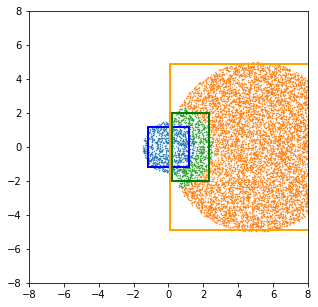

---------- Training orig ----------
Added pepper=0.1 random negatives on 3/3 LFs
Saving model at iteration 0 with best score 0.913
[E:0]	Train Loss: 5.677	Dev accuracy: 0.913
[E:1]	Train Loss: 4.531	Dev accuracy: 0.913
[E:2]	Train Loss: 4.419	Dev accuracy: 0.913
[E:3]	Train Loss: 4.390	Dev accuracy: 0.913
Saving model at iteration 4 with best score 0.956
[E:4]	Train Loss: 4.377	Dev accuracy: 0.956
Saving model at iteration 5 with best score 0.957
[E:5]	Train Loss: 4.367	Dev accuracy: 0.957
[E:6]	Train Loss: 4.360	Dev accuracy: 0.957
[E:7]	Train Loss: 4.351	Dev accuracy: 0.957
[E:8]	Train Loss: 4.361	Dev accuracy: 0.957
[E:9]	Train Loss: 4.351	Dev accuracy: 0.957
Saving model at iteration 10 with best score 0.958
[E:10]	Train Loss: 4.352	Dev accuracy: 0.958
[E:11]	Train Loss: 4.350	Dev accuracy: 0.958
[E:12]	Train Loss: 4.341	Dev accuracy: 0.957
[E:13]	Train Loss: 4.340	Dev accuracy: 0.957
[E:14]	Train Loss: 4.334	Dev accuracy: 0.957
[E:15]	Train Loss: 4.331	Dev accuracy: 0.958
[E:16]	T

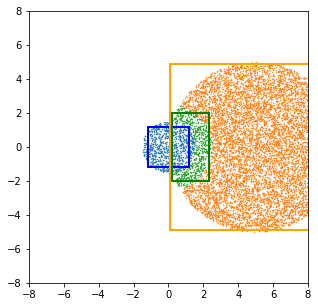

---------- Training orig ----------
Added pepper=0.1 random negatives on 3/3 LFs
Saving model at iteration 0 with best score 0.908
[E:0]	Train Loss: 5.462	Dev accuracy: 0.908
Saving model at iteration 1 with best score 0.936
[E:1]	Train Loss: 4.369	Dev accuracy: 0.936
[E:2]	Train Loss: 4.310	Dev accuracy: 0.935
Saving model at iteration 3 with best score 0.936
[E:3]	Train Loss: 4.297	Dev accuracy: 0.936
[E:4]	Train Loss: 4.291	Dev accuracy: 0.933
[E:5]	Train Loss: 4.279	Dev accuracy: 0.933
Saving model at iteration 6 with best score 0.937
[E:6]	Train Loss: 4.274	Dev accuracy: 0.937
Saving model at iteration 7 with best score 0.945
[E:7]	Train Loss: 4.279	Dev accuracy: 0.945
Saving model at iteration 8 with best score 0.948
[E:8]	Train Loss: 4.264	Dev accuracy: 0.948
Saving model at iteration 9 with best score 0.949
[E:9]	Train Loss: 4.255	Dev accuracy: 0.949
Saving model at iteration 10 with best score 0.949
[E:10]	Train Loss: 4.258	Dev accuracy: 0.949
Saving model at iteration 11 with

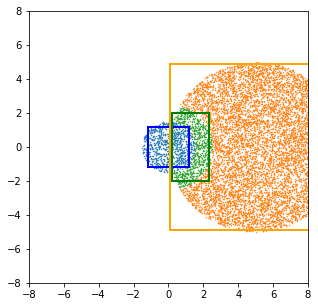

---------- Training orig ----------
Added pepper=0.1 random negatives on 3/3 LFs
Saving model at iteration 0 with best score 0.941
[E:0]	Train Loss: 5.947	Dev accuracy: 0.941
Saving model at iteration 1 with best score 0.943
[E:1]	Train Loss: 4.346	Dev accuracy: 0.943
Saving model at iteration 2 with best score 0.947
[E:2]	Train Loss: 4.228	Dev accuracy: 0.947
Saving model at iteration 3 with best score 0.952
[E:3]	Train Loss: 4.201	Dev accuracy: 0.952
Saving model at iteration 4 with best score 0.955
[E:4]	Train Loss: 4.196	Dev accuracy: 0.955
[E:5]	Train Loss: 4.190	Dev accuracy: 0.951
[E:6]	Train Loss: 4.191	Dev accuracy: 0.950
[E:7]	Train Loss: 4.180	Dev accuracy: 0.955
[E:8]	Train Loss: 4.181	Dev accuracy: 0.948
[E:9]	Train Loss: 4.184	Dev accuracy: 0.919
[E:10]	Train Loss: 4.184	Dev accuracy: 0.950
[E:11]	Train Loss: 4.181	Dev accuracy: 0.949
[E:12]	Train Loss: 4.180	Dev accuracy: 0.954
[E:13]	Train Loss: 4.189	Dev accuracy: 0.952
[E:14]	Train Loss: 4.182	Dev accuracy: 0.951
[E:1

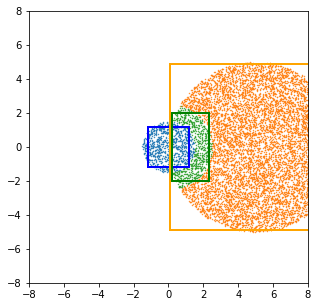

---------- Training orig ----------
Added pepper=0.1 random negatives on 3/3 LFs
Saving model at iteration 0 with best score 0.919
[E:0]	Train Loss: 5.532	Dev accuracy: 0.919
Saving model at iteration 1 with best score 0.940
[E:1]	Train Loss: 4.787	Dev accuracy: 0.940
Saving model at iteration 2 with best score 0.954
[E:2]	Train Loss: 4.514	Dev accuracy: 0.954
Saving model at iteration 3 with best score 0.958
[E:3]	Train Loss: 4.441	Dev accuracy: 0.958
[E:4]	Train Loss: 4.409	Dev accuracy: 0.940
Saving model at iteration 5 with best score 0.961
[E:5]	Train Loss: 4.397	Dev accuracy: 0.961
Saving model at iteration 6 with best score 0.962
[E:6]	Train Loss: 4.386	Dev accuracy: 0.962
[E:7]	Train Loss: 4.384	Dev accuracy: 0.931
Saving model at iteration 8 with best score 0.962
[E:8]	Train Loss: 4.374	Dev accuracy: 0.962
[E:9]	Train Loss: 4.379	Dev accuracy: 0.961
[E:10]	Train Loss: 4.364	Dev accuracy: 0.962
Saving model at iteration 11 with best score 0.965
[E:11]	Train Loss: 4.371	Dev accu

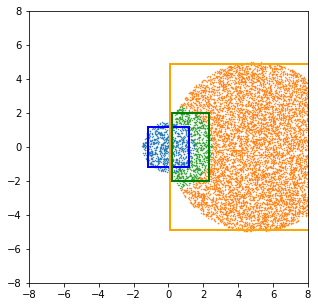

---------- Training orig ----------
Added pepper=0.1 random negatives on 3/3 LFs


Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x12cae7830>
Traceback (most recent call last):
  File "/Users/vincentchen/miniconda3/envs/slicing/lib/python3.6/site-packages/tqdm/_tqdm_notebook.py", line 226, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


ValueError: not enough values to unpack (expected 2, got 1)

In [14]:
%%time
from collections import defaultdict

from metal.label_model import MajorityLabelVoter
from metal.utils import split_data
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
from metal.contrib.slicing.experiment_utils import (
    create_data_loader,
    train_model,
    search_upweighting_models,
    eval_model
)
from metal.contrib.slicing.utils import get_L_weights_from_targeting_lfs_idx
from metal.contrib.slicing.mixture_of_experts import train_MoE_model


model_configs = {
#     "UNI": uni_config,
#     "UPx2": up_config,
#     "MoE": moe_config,
#     "DP": dp_config,
#     "SM": sm_config,
    'orig': orig
}

NUM_TRIALS = 50
NUM_SLICES = 2
K = 2
M = 20
N = 10000
unipolar = False
pepper = 0.1
print(f"Pepper: {pepper}")
# A base to add to trial number to set a unique seed for each trial
salt = 42 #np.random.randint(1e6)
print(f"Salt: {salt}")


history = defaultdict(list)
for trial in range(NUM_TRIALS):
    print(f"[Trial {trial}]")

    L_kwargs = {'max_r': 7} if unipolar else {'max_r': 5} 
    Z_kwargs = {'num_slices': NUM_SLICES}
    X, Y, Z, L = generate_pacman_data(
        config
    )
    target_lfs_idx = [3]

    Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)
    L_train_raw = Ls[0].copy() # TEMP
    
    for model_name, model_config in model_configs.items():
        print ("-"*10, "Training", model_name, "-"*10)

        Ls[0] = L_train_raw.copy() # TEMP: Reset to unpeppered version
        
        # Generate weak labels:
        if model_name == "UNI" or model_name.startswith("UP"):
            Y_train = MajorityLabelVoter().predict_proba(Ls[0])            
        else:
            label_model = SnorkelLabelModel()
            label_model.train_model(Ls[0])
            Y_train = label_model.predict_proba(Ls[0])
        Ys[0] = Y_train
        
        from metal.contrib.slicing.utils import add_pepper
        Ls[0] = add_pepper(Ls[0], pepper)        
        
        # Train end model
        if model_name == "UNI":
            L_weights = list(np.ones(M))
            model = train_model(model_config, Ls, Xs, Ys, Zs, L_weights)
        elif model_name.startswith('UP'):
            model = search_upweighting_models(model_config, Ls, Xs, Ys, Zs, 
                                              targeting_lfs_idx, verbose=False)
        elif model_name == "MoE":
            model = train_MoE_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "DP":
            model = train_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "SM":
            model = train_model(model_config, Ls, Xs, Ys, Zs)        
        elif model_name == 'orig':
            model = train_orig(model_config, Ls, Xs, Ys, Zs)
        else:
            raise Exception(f"Unrecognized model_name: {model_name}")
            
        test_loader = create_data_loader(Ls, Xs, Ys, Zs, model_config, 'test')
        results = eval_model(model, test_loader, verbose=False, summary=False)        
        
        # Save results
        history[model_name].append(results)

In [16]:
from metal.contrib.slicing.experiment_utils import parse_history

print(f"Average (n={NUM_TRIALS}):")
df = parse_history(history, NUM_SLICES)
df

Average (n=50):


,orig
all,0.957756
slice_0,0.504832
slice_1,1.000000
slice_avg,0.752416
